# Neural Quantum Dynamics Emulator (Part III)

### Scope of this notebook

1. We include the full model test results.
2. We show the hyper-parameter tuning results.
3. We show how to calculate and visulize the input-feature importance.

In [2]:
# Import libraries
import os
import random
import math
import time
import datetime
import collections
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation

from tensorflow import keras
from tensorflow.keras import layers
from matplotlib.animation import FuncAnimation
from optimization import create_optimizer
from IPython.display import HTML
from utils import *
from models import *

## Section 7: Full Models Results


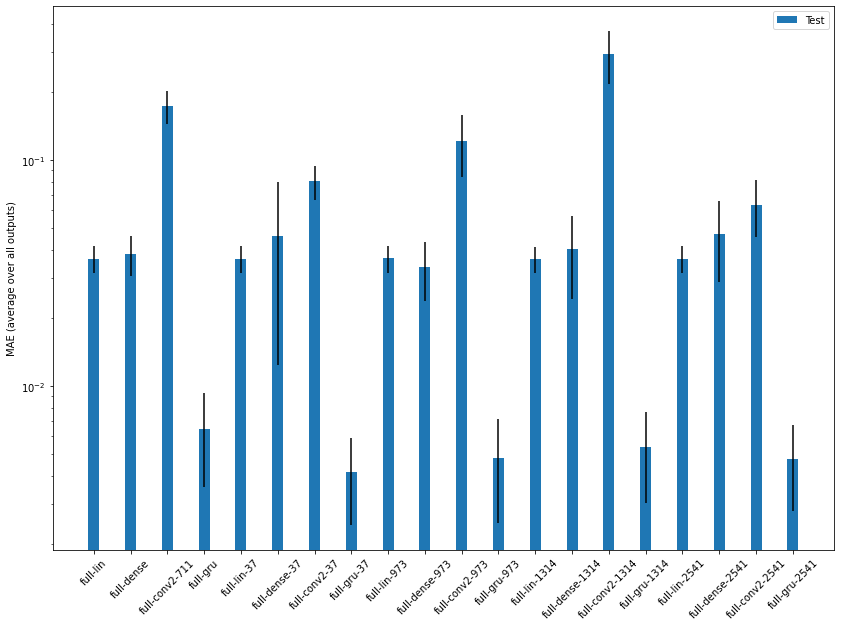

In [16]:
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
npzfile = np.load("new-full.npz")
fig = plt.figure(figsize=(14, 10))
x = np.arange(len(npzfile["ckpts"]))
width = 0.3

all_loss = npzfile["all_loss"]
test_mae = np.mean(all_loss, axis = (1, 2))
test_std = np.std(np.mean(all_loss, axis = 2), axis = 1)
metric_name = 'mean_absolute_error'

# plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x, test_mae, width, yerr=test_std, label='Test')
plt.xticks(ticks=x, labels=npzfile["ckpts"],
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
plt.yscale('log')
_ = plt.legend()

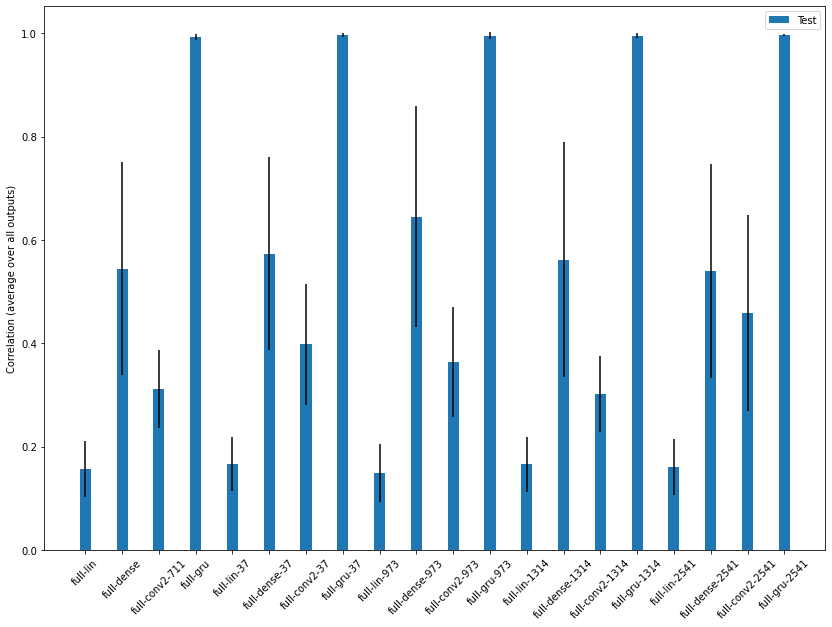

In [17]:
npzfile = np.load("new-full.npz")
fig = plt.figure(figsize=(14, 10))
x = np.arange(len(npzfile["ckpts"]))
width = 0.3

all_loss = npzfile["all_corr"]
test_mae = np.mean(all_loss, axis = (1, 2))
test_std = np.std(np.mean(all_loss, axis = 2), axis = 1)
metric_name = 'mean_absolute_error'

# plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x, test_mae, width, yerr=test_std, label='Test')
plt.xticks(ticks=x, labels=npzfile["ckpts"],
           rotation=45)
plt.ylabel('Correlation (average over all outputs)')
# plt.yscale('log')
_ = plt.legend()

We can build the animation for a specific model with a specific test file to see the actual performance of it.

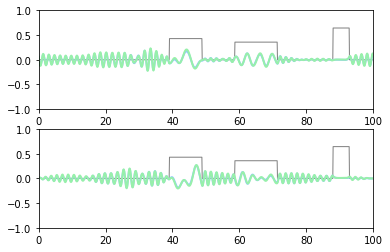

In [18]:
test_file = "../datasets/test/full_test_E0_0.0to9.0_BH_0.0to14.0/triple.txt"
pot_scalar = 14.0
ckpt = "../models/full-gru/ckpts/final_step"
config = Config(input_channels=3, hidden_size=69)
model = RNNModel(config)

data = retrieve_data(test_file, pot_scalar)
model.load_weights(ckpt)
result = get_result(model, config, data)
anim = build_anime(config, data, result)
HTML(anim.to_html5_video())

Text(0.5, 1.0, 'Difference')

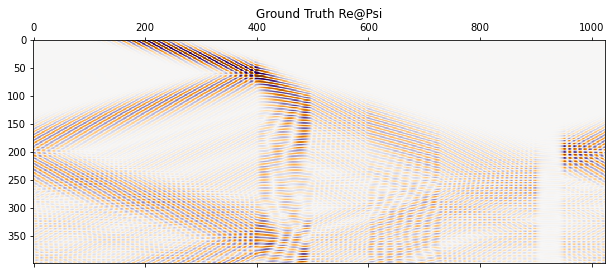

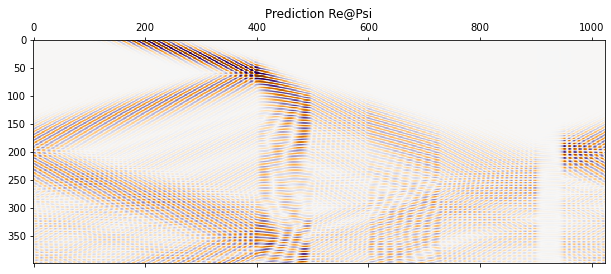

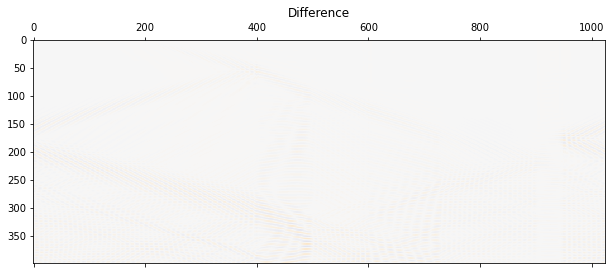

In [20]:
frames = result.shape[0]
plt.matshow(data["psi_re"][config.input_frames:config.input_frames+frames], vmax=0.4, vmin=-0.4, cmap="PuOr")
plt.title("Ground Truth Re@Psi")
plt.matshow(result[:, :, 0], vmax=0.4, vmin=-0.4, cmap="PuOr")
plt.title("Prediction Re@Psi")
plt.matshow(data["psi_re"][config.input_frames:config.input_frames+frames]-result[:, :, 0], vmax=0.4, vmin=-0.4, cmap="PuOr")
plt.title("Difference")

## Section 8: Hyperparameters Tuning


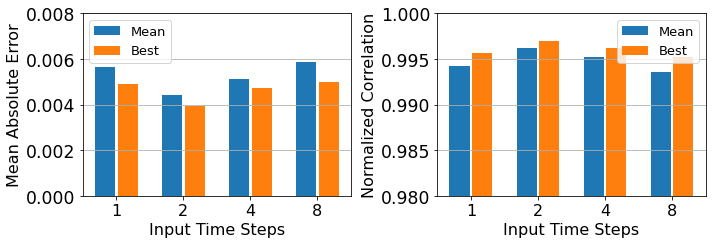

In [8]:
plt.rc('xtick', labelsize='xx-large')
plt.rc('ytick', labelsize='xx-large')
fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))
npzfile = np.load("frame.npz")
x = np.arange(4)
width = 0.3

all_loss = npzfile["all_loss"]
mae = np.mean(all_loss, axis = (1, 2))
best_mae = [np.min(mae[x::4]) for x in range(4)]
mean_mae = [np.mean(mae[x::4]) for x in range(4)]
metric_name = 'mean_absolute_error'

axs[0].bar(x - 0.17, mean_mae, width, label='Mean')
axs[0].bar(x + 0.17, best_mae, width, label='Best')
axs[0].set_xticks(x)
axs[0].set_xticklabels(["1", "2", "4", "8"], fontsize=16)
axs[0].set_xlabel("Input Time Steps", fontsize=16)
axs[0].set_ylabel('Mean Absolute Error', fontsize=16)


all_loss = npzfile["all_corr"]
mae = np.mean(all_loss, axis = (1, 2))
best_mae = [np.max(mae[x::4]) for x in range(4)]
mean_mae = [np.mean(mae[x::4]) for x in range(4)]
metric_name = 'mean_absolute_error'

axs[1].bar(x - 0.17, mean_mae, width, label='Mean')
axs[1].bar(x + 0.17, best_mae, width, label='Best')
axs[1].set_xticks(x)
axs[1].set_xticklabels(["1", "2", "4", "8"], fontsize=16)
axs[1].set_xlabel("Input Time Steps", fontsize=16)
axs[1].set_ylabel('Normalized Correlation', fontsize=16)
axs[1].set_ylim((0.98, 1.0))
axs[0].set_ylim((0., 0.008))

# plt.yscale('log')
axs[0].grid(axis='y')
axs[0].legend(fontsize=13)
axs[1].legend(fontsize=13)
axs[1].grid(axis='y')

fig.tight_layout()


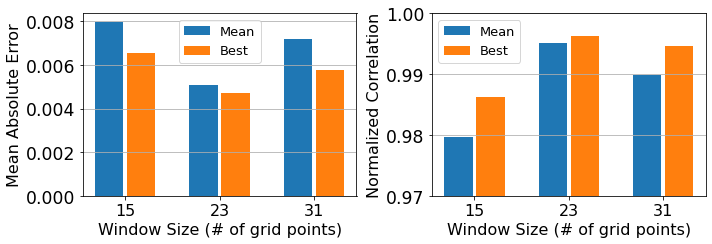

In [10]:
plt.rc('xtick', labelsize='xx-large')
plt.rc('ytick', labelsize='xx-large')
npzfile = np.load("window.npz")
fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))
x = np.arange(3)
width = 0.3

all_loss = npzfile["all_loss"]
mae = np.mean(all_loss, axis = (1, 2))
best_mae = [np.min(mae[x::3]) for x in range(3)]
mean_mae = [np.mean(mae[x::3]) for x in range(3)]
metric_name = 'mean_absolute_error'

axs[0].bar(x - 0.17, mean_mae, width, label='Mean')
axs[0].bar(x + 0.17, best_mae, width, label='Best')
axs[0].set_xticks(x)
axs[0].set_xticklabels(["15", "23", "31",], fontsize=16)
axs[0].set_xlabel("Window Size (# of grid points)", fontsize=16)
axs[0].set_ylabel('Mean Absolute Error', fontsize=16)


all_loss = npzfile["all_corr"]
mae = np.mean(all_loss, axis = (1, 2))
best_mae = [np.max(mae[x::3]) for x in range(3)]
mean_mae = [np.mean(mae[x::3]) for x in range(3)]
metric_name = 'mean_absolute_error'

axs[1].bar(x - 0.17, mean_mae, width, label='Mean')
axs[1].bar(x + 0.17, best_mae, width, label='Best')
axs[1].set_xticks(x)
axs[1].set_xticklabels(["15", "23", "31",], fontsize=16)
axs[1].set_xlabel("Window Size (# of grid points)", fontsize=16)
axs[1].set_ylabel('Normalized Correlation', fontsize=16)
axs[1].set_ylim((0.97, 1.0))

# plt.yscale('log')
axs[0].grid(axis='y')
axs[0].legend(fontsize=13)
axs[1].legend(fontsize=13)
axs[1].grid(axis='y')

fig.tight_layout()
# plt.savefig('pt-window.pdf')


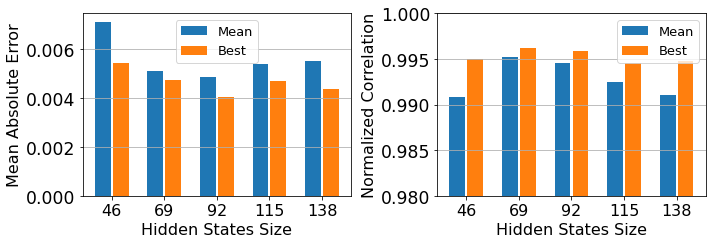

In [11]:
plt.rc('xtick', labelsize='xx-large')
plt.rc('ytick', labelsize='xx-large')
npzfile = np.load("hidden.npz")
fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))
x = np.arange(5)
x1 = [3, 5, 6, 7, 8]
width = 0.3

all_loss = npzfile["all_loss"]
mae = np.mean(all_loss, axis = (1, 2))
best_mae = [np.min(mae[x::9]) for x in x1]
mean_mae = [np.mean(mae[x::9]) for x in x1]
metric_name = 'mean_absolute_error'

# print(x)

axs[0].bar(x - 0.17, mean_mae, width, label='Mean')
axs[0].bar(x + 0.17, best_mae, width, label='Best')
axs[0].set_xticks(x)
axs[0].set_xticklabels(["46", "69", "92", "115", "138"], fontsize=16)
axs[0].set_xlabel("Hidden States Size", fontsize=16)
axs[0].set_ylabel('Mean Absolute Error', fontsize=16)


all_loss = npzfile["all_corr"]
mae = np.mean(all_loss, axis = (1, 2))
best_mae = [np.max(mae[x::9]) for x in x1]
mean_mae = [np.mean(mae[x::9]) for x in x1]
metric_name = 'mean_absolute_error'

axs[1].bar(x - 0.17, mean_mae, width, label='Mean')
axs[1].bar(x + 0.17, best_mae, width, label='Best')
axs[1].set_xticks(x)
axs[1].set_xticklabels(["46", "69", "92", "115", "138"], fontsize=16)
axs[1].set_xlabel("Hidden States Size", fontsize=16)
axs[1].set_ylabel('Normalized Correlation', fontsize=16)

axs[1].set_ylim((0.98, 1.0))

# plt.yscale('log')
axs[0].grid(axis='y')
axs[0].legend(fontsize=13)
axs[1].legend(fontsize=13)
axs[1].grid(axis='y')

fig.tight_layout()


## Section 9: Input-feature Importance


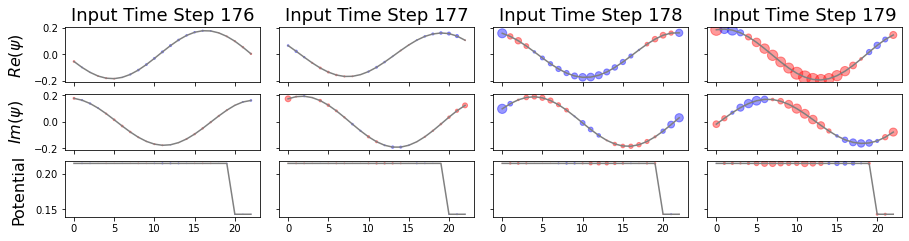

In [4]:
def compute_gradients(model, inputs, target):
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        pred = model(inputs)
        pred = pred[0, target[0], target[1]]
    return tape.gradient(pred, inputs)


def plot_ig(model, config, data, frame_num=0, window_num=500, target=(11, 0), bp=True):
    def build_plot(config, feature, resp, window_num):
        ylabel = ["$Re(\psi)$", "$Im(\psi)$", "Potential"]
        fig, axs = plt.subplots(3, 4, sharex=True, sharey='row', figsize=(15,3.5), )
        resp = resp.reshape(feature.shape)
        for i in range(4):
            for j in range(config.input_channels):
                x = np.arange(feature.shape[1])
                y = feature[i, :, j]
                s = resp[i, :, j]
                axs[j, i].plot(y, c="gray")
                spos = np.maximum(s, 0)
                sneg = np.minimum(s, 0)
                axs[j, i].scatter(x, y, c="red", s=1e3*np.abs(spos), alpha=0.4,)
                axs[j, i].scatter(x, y, c="blue", s=1e3*np.abs(sneg), alpha=0.4,)
                
                if j == 0:
                    axs[j, i].set_title(f"Input Time Step {i+176}", fontsize=18)
                if i == 0:
                    axs[j, i].set_ylabel(ylabel[j], fontsize=16)
                    axs[j, i].yaxis.set_label_coords(-0.2, 0.5)
                    
        plt.subplots_adjust(wspace=0.1, hspace=0.2)


    features = tf.stack((tf.constant(data["psi_re"], dtype=tf.float32), 
                         tf.constant(data["psi_im"], dtype=tf.float32), 
                         tf.constant(data["pot"], dtype=tf.float32)), axis=-1)
    feature = features[frame_num:frame_num+config.input_frames, window_num:window_num+config.window_size, :config.input_channels].numpy()
    
    g = compute_gradients(model, tf.constant([feature]), target=target)
    if bp:
        build_plot(config, feature, g.numpy(), window_num)
    return g.numpy()


test_file = "../datasets/test/full_test_E0_0.0to9.0_BH_0.0to14.0/steps.txt"

pot_scalar = 14.
ckpt = "../models/full-gru/ckpts/final_step"
config = Config()
model = RNNModel(config)
data = retrieve_data(test_file, pot_scalar)
model.load_weights(ckpt)
g = plot_ig(model, config, data, 176, 660, (11, 0))

# plt.savefig('response.pdf', bbox_inches = 'tight', pad_inches = 0)


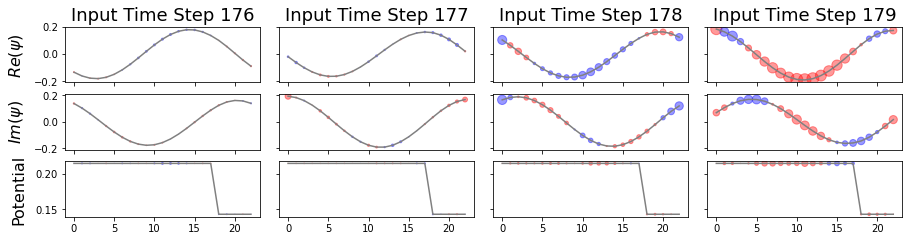

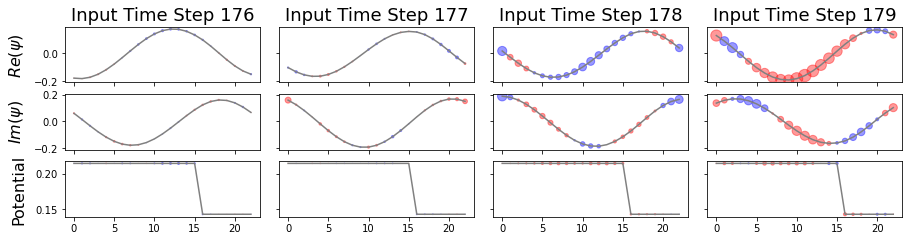

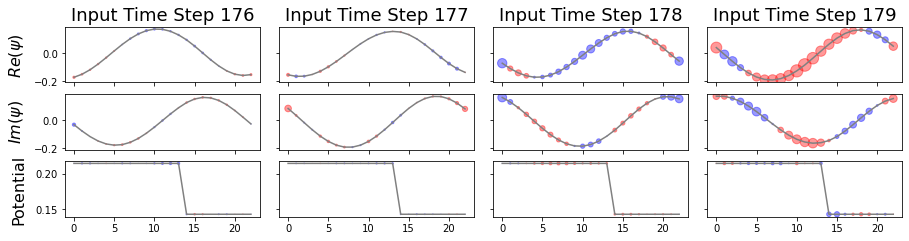

In [5]:
g = plot_ig(model, config, data, 176, 662, (11, 0))
g = plot_ig(model, config, data, 176, 664, (11, 0))
g = plot_ig(model, config, data, 176, 66, (11, 0))